In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("HW3") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/06 11:26:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
import json

tweets_rdd = sc.textFile("twitter_data_v2.jsonl")

# Parse JSON strings to Python dictionaries
tweets_json = tweets_rdd.map(json.loads)
del tweets_rdd

tweets_json.take(5)

[{'in_reply_to_status_id_str': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_status_id': None,
  'in_reply_to_user_id': None,
  'in_reply_to_screen_name': None,
  'truncated': False,
  'is_quote_status': False,
  'retweet_count': 151,
  'reply_count': 0,
  'quote_count': 0,
  'favorite_count': 0,
  'favorited': False,
  'retweeted': True,
  'possibly_sensitive': None,
  'lang': 'fa',
  'geo': None,
  'view_count': 0,
  'tweet_type': 'retweeted',
  'emojis': None,
  'text': '¬´ÿÆŸÖ€åŸÜ€å ÿ±ÿß ÿ®ÿßÿ≤ÿ±⁄ØÿßŸÜ Ÿà €åÿ≤ÿØ€å ŸàŸÇÿ∑ÿ®\u200cÿ≤ÿßÿØŸá Ÿà ÿ®ŸÜ€å ÿµÿØÿ± Ÿà ÿ∑ÿ®ÿßÿ∑ÿ®ÿß€å€å  ÿ≠ŸÖÿß€åÿ™ ⁄©ÿ±ÿØŸÜÿØ Ÿà ŸÜŸàŸÅŸÑ ŸÑŸàÿ¥ÿßÿ™Ÿà ÿ±Ÿà ÿ¨ŸáÿßŸÜ€å¬ª\n\nÿ¥Ÿàÿ±ÿ¥ €µ€∑ ÿÆÿßÿ±ÿ¨ ÿßÿ≤ ÿß€åÿ±ÿßŸÜ ÿØŸÜÿ®ÿßŸÑ ÿ¥ÿØ Ÿà ÿ™ÿ®ŸÑ€åÿ∫ÿßÿ™ ÿ±ÿ≥ÿßŸÜŸá ÿß€å Ÿà Ÿæÿ±ŸàŸæÿß⁄ØÿßŸÜÿØÿß€å Ÿàÿ≥€åÿπ€å  ÿÆÿßÿ±ÿ¨ ÿßÿ≤ ⁄©ÿ¥Ÿàÿ± ÿ®ÿ±ÿß€å ÿÆŸÖ€åŸÜ€å ÿµŸàÿ±ÿ™ ⁄Øÿ±ŸÅÿ™.\nŸæÿ±ŸàŸæÿß⁄ØÿßŸÜÿØÿß€å€å ⁄©Ÿá ÿßÿ≤ ÿ±€åÿ¥Ÿá ÿ®ÿ± Ÿæÿß€åŸá ÿØÿ±Ÿàÿ∫ Ÿà ŸÜ€åÿ±ŸÜ⁄Ø ÿ¥⁄©ŸÑ ⁄Øÿ±ŸÅÿ™.\n  ÿßŸÑÿ®ÿ™Ÿá ŸÖÿß ÿ≥€åÿßÿ≥ÿ™ŸÖÿØÿßÿ±€å ŸÖÿßŸÜŸÜÿ

## Near-Duplicate Detection Streaming

In [1]:
import time
from datasketch import MinHash, LeanMinHash
import xxhash
from pyspark.streaming import StreamingContext

hash_table = set()

def minhash(seq, num_perm=256):
    m = MinHash(num_perm=num_perm, hashfunc=xxhash.xxh64_intdigest)
    for s in list(seq):
        m.update(s.encode('utf8'))
    return LeanMinHash(m)

# Define a function to check if two tweets are near-duplicate
def is_near_duplicate(tweet1, tweet2):
  # Calculate the Jaccard similarity between the MinHash values
  jaccard_similarity =  tweet1.jaccard(tweet2)
  # Define a threshold for near-duplicate, e.g. 0.95
  threshold = 0.95
  # Check if the Jaccard similarity is greater than or equal to the threshold
  if jaccard_similarity >= threshold:
    # The tweets are near-duplicate
    return True
  else:
    # The tweets are not near-duplicate
    return False


# Create a StreamingContext
ssc = StreamingContext(sc, 1) # 1 second batch interval


processed_tweets = tweets_json.filter(lambda x: x['tweet_type'] != 'retweeted').map(lambda x: (x["text"], x.get('user').get('verified'), x['id']))


samples, _ = processed_tweets.randomSplit([0.0005, 1 - 0.0005], seed=42)


# Create a RDD queue from the JSON RDD
rddQueue = samples.randomSplit([0.5, 0.5], seed=42)

# Create a DStream from the RDD queue
inputStream = ssc.queueStream(rddQueue)

# Define a function to process each RDD in the DStream
def process_rdd(rdd):
  # Loop through each tweet in the RDD
  spam_count = 0
  total_count = 0
  for tweet in rdd.collect():
    total_count += 1
    #if tweet[2] != 'retweeted':
    if tweet[1] != True:
        for previous_tweet in hash_table:
              # Check if the tweet is near-duplicate
          if is_near_duplicate(minhash(tweet[0]), previous_tweet):
      # Label the tweet as spam
            print(f'The tweet with ID {tweet[2]} and below text is spam:\n')
            print(tweet[0])
            spam_count += 1
            continue
    hash_table.add(minhash(tweet[0])) # Add verified tweets which are not retweet of another tweet

  print(spam_count)
  print(total_count)
  

# Apply the function to each RDD in the DStream
inputStream.foreachRDD(process_rdd)

# Start the streaming computation
ssc.start()
#time.sleep(6)
ssc.stop(stopSparkContext=True, stopGraceFully=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/06 01:00:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/06 01:00:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/usr/local/lib/python3.10/dist-packages/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(
24/02/06 01:01:06 WARN JobGenerator: Timed out while stopping the job generator (timeout = 10000)


0
602


The tweet with ID 1735210946996363626 and below text is spam:

ÿ®Ÿá ŸÖÿßÿØÿ± ŸÇŸàŸÑ ÿØÿßÿØŸá ÿ®ŸàÿØ ÿ®ÿ± ŸÖ€å ⁄Øÿ±ÿØÿØ ‚Ä¶
⁄Üÿ¥ŸÖ ŸÖÿßÿØÿ± ⁄©Ÿá ÿ®Ÿá ÿßÿ≥ÿ™ÿÆŸàÿßŸÜ Ÿáÿß€å ÿ®€å ÿ¨ŸÖÿ¨ŸÖŸá ÿßŸÅÿ™ÿßÿØ
ŸÑÿ®ÿÆŸÜÿØ ÿ™ŸÑÿÆ€å ÿ≤ÿØ Ÿà ⁄ØŸÅÿ™ :
ÿ®⁄ÜŸá ŸÖ ÿ≥ÿ±ÿ¥ ŸÖ€å ÿ±ŸÅÿ™ ŸàŸÑ€å ŸÇŸàŸÑÿ¥ ŸÜŸÖ€å ÿ±ŸÅÿ™ ‚Ä¶
#ŸàÿØÿßÿπ_ÿ®ÿß_ŸÑÿßŸÑŸá‚ÄåŸáÿß 
#ŸÖŸáŸÖÿßŸÜ_ŸÖÿßÿØÿ±
The tweet with ID 1735020260640633042 and below text is spam:

ÿß€åÿ±ÿßŸÜ€å ŸÜÿ®ŸàÿØŸÜ ŸàŸÑ€å ÿØŸàÿ¥ÿßÿØŸàÿ¥ ÿß€åÿ±ÿßŸÜ€åÿßŸÜ ŸÖÿ®ÿßÿ±ÿ≤Ÿá ⁄©ÿ±ÿØ Ÿà ÿ¨ÿßŸÜ ÿØÿßÿØÿå ÿ¢ÿ≤ÿßÿØ€å Ÿà ÿ¢ÿ≤ÿßÿØ ÿßŸÜÿØ€åÿ¥€å ŸÖÿ±ÿ≤ ŸÜŸÖ€åÿ¥ŸÜÿßÿ≥Ÿá
ÿ±ÿ∂ÿß ÿ≥ÿ±Ÿàÿ±€å
ÿ≥ÿ™ÿßÿ±Ÿá ÿ™ÿßÿ¨€å⁄©
Ÿáÿßÿ±ŸàŸÜ ÿµÿØ€åŸÇ€å
Ÿà ÿ®ŸÇ€åŸá ÿßŸàŸÜÿß€å€å ⁄©Ÿá ⁄ØŸÖŸÜÿßŸÖ ŸÖŸàŸÜÿØŸÜ https://t.co/MigAOoldpe
2
605


## More Data Analysis

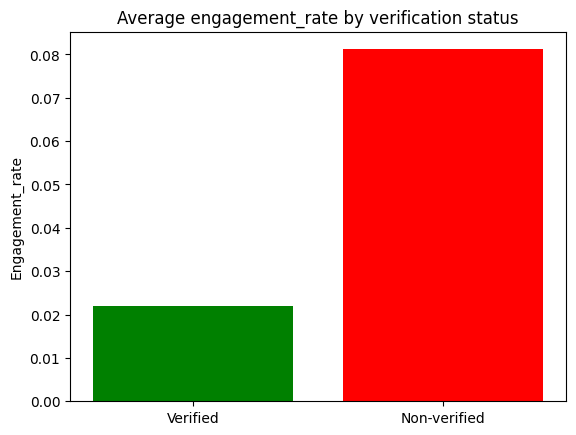

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to extract the engagement_rate and verification status of the users from each tweet
def get_engagement_verified(tweet):
  engagement_rate = tweet["engagement_rate"]
  verified = tweet["user"]["verified"]
  return engagement_rate, verified

# Apply the function to your tweet data using map
engagement_rdd = tweets_json.map(get_engagement_verified)

# Filter the verified and non-verified users into two RDDs
verified_rdd = engagement_rdd.filter(lambda x: x[1] == True)
non_verified_rdd = engagement_rdd.filter(lambda x: x[1] == False)

# Calculate the average engagement_rate for each group using mean function
verified_mean = verified_rdd.map(lambda x: x[0]).mean()
non_verified_mean = non_verified_rdd.map(lambda x: x[0]).mean()

# Create a list of labels and values for plotting
labels = ["Verified", "Non-verified"]
values = [verified_mean, non_verified_mean]

plt.bar(labels, values, color=["green", "red"])
plt.title("Average engagement_rate by verification status")
plt.ylabel("Engagement_rate")
plt.show()

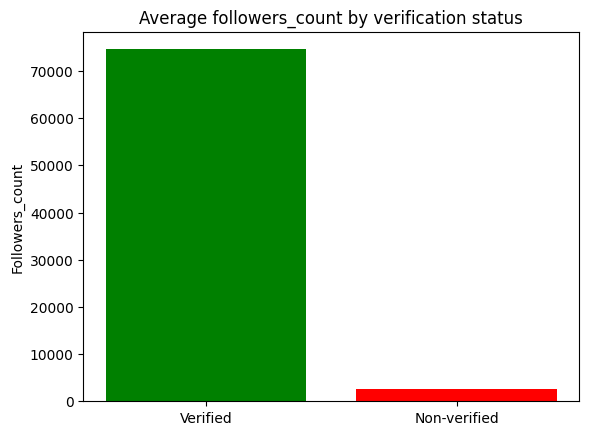

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to extract the followers_count and verification status of the users from each tweet
def get_followers_verified(tweet):
  followers_count = tweet["user"]["followers_count"]
  verified = tweet["user"]["verified"]
  return followers_count, verified

# Apply the function to your tweet data using map
followers_rdd = tweets_json.map(get_followers_verified)

# Filter the verified and non-verified users into two RDDs
verified_rdd = followers_rdd.filter(lambda x: x[1] == True)
non_verified_rdd = followers_rdd.filter(lambda x: x[1] == False)

# Calculate the average followers_count for each group using mean function
verified_mean = verified_rdd.map(lambda x: x[0]).mean()
non_verified_mean = non_verified_rdd.map(lambda x: x[0]).mean()

# Create a list of labels and values for plotting
labels = ["Verified", "Non-verified"]
values = [verified_mean, non_verified_mean]

# Plot the results as a bar chart
plt.bar(labels, values, color=["green", "red"])
plt.title("Average followers_count by verification status")
plt.ylabel("Followers_count")
plt.show()

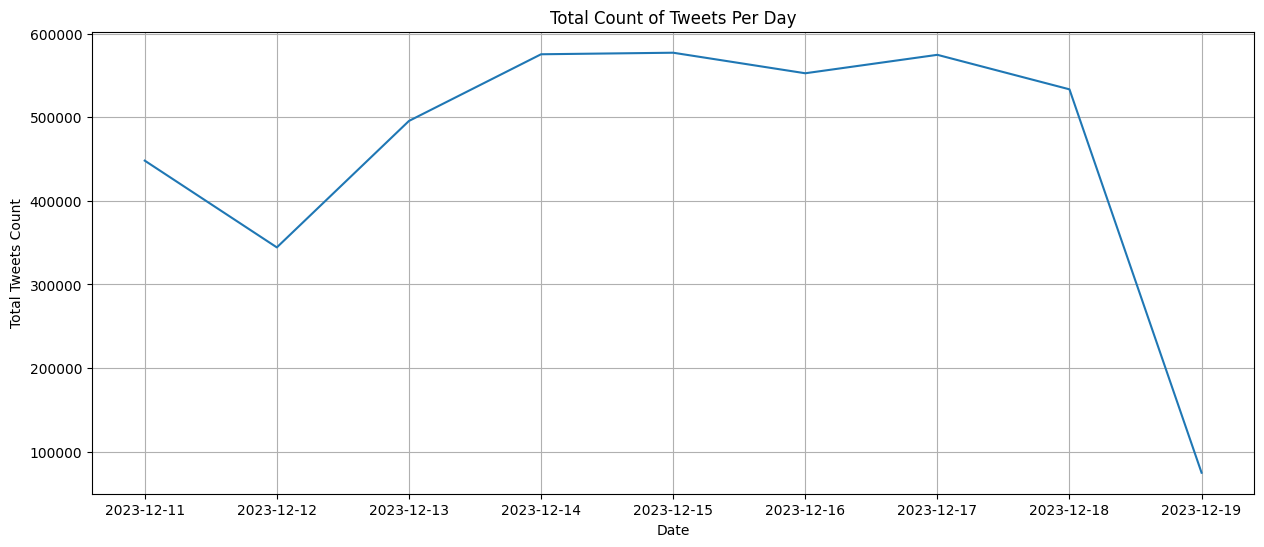

In [4]:
import time
import matplotlib.pyplot as plt

tweets_per_day_rdd = tweets_json.map(lambda x: (time.strftime('%Y-%m-%d', time.localtime(int(x['created_at']))), 1)) \
                           .reduceByKey(lambda a, b: a + b)

# Collect the data and sort by date
tweets_per_day = sorted(tweets_per_day_rdd.collect())

# Plot the timeline
dates, counts = zip(*tweets_per_day)
plt.figure(figsize=(15,6))
plt.plot(dates, counts)
plt.xticks()
plt.xlabel('Date')
plt.ylabel('Total Tweets Count')
plt.title('Total Count of Tweets Per Day')
plt.grid()
plt.show()

# HashTags

In [3]:
import re

def hashtag_extractor(text):
    return re.findall(r'#(\w+)', text)

hashtag_tweets = tweets_json.map(lambda x: (x['id'], hashtag_extractor(x['text']))).filter(lambda x: x[1])

hashtag_tweets.take(20)

[('1736536753815834746', ['ÿ±ÿ∂ÿßÿ¥ÿßŸá_ÿØŸàŸÖ', 'ÿ¨ÿßŸà€åÿØÿ¥ÿßŸá']),
 ('1736536756915249313',
  ['ŸÖÿ±€åŸÖ', 'ŸÖÿ±ŸäŸÖ_ÿ±ÿ¨ŸàŸä', 'ŸÇ€åÿßŸÖ_ÿ™ÿß_ÿ≥ÿ±ŸÜ⁄ØŸàŸÜ€å', 'ŸÖÿ±⁄Ø_ÿ®ÿ±_ÿÆÿßŸÖŸÜŸá']),
 ('1736536767254134968', ['ŸàÿØÿßÿπ_ÿ®ÿß_ŸÑÿßŸÑŸá', 'ŸÅÿ±ÿ≤ŸÜÿØÿßŸÜ_ÿ≤Ÿáÿ±ÿß']),
 ('1736536771129741402',
  ['ÿ¨ÿßŸà€åÿØ_ÿ±ÿ∂ÿßÿ¥ÿßŸá_ÿ∞ŸàŸÖ', 'ŸÜŸÜ⁄Ø_ÿ®ÿ±_ŸÅÿ™ŸÜŸá€µ€∑', 'ŸÜŸÜ⁄Ø_ÿ®ÿ±_ÿ≥Ÿá_ŸÅÿßÿ≥ÿØ_ŸÖŸÑÿß_⁄ÜŸæ€å_ŸÖÿ¨ÿßŸáÿØ']),
 ('1736536778423607618', ['FreeHamidNouri']),
 ('1736536778704875794', ['ŸÖŸáÿ≥ÿß_ÿßŸÖ€åŸÜ€å']),
 ('1736536782022246546', ['ÿ∫ÿ≤ÿ©', 'ŸÅŸÑÿ≥ÿ∑€åŸÜ', 'ÿßŸÜÿ≠ŸÑÿßŸÑ_ÿ≥ŸæÿßŸá_Ÿæÿßÿ≥ÿØÿßÿ±ÿßŸÜ']),
 ('1736536778926919959', ['ÿ≥ÿßÿ≥€å']),
 ('1736536785381908978', ['ÿ¨ÿßŸà€åÿØ_ÿ±ÿ∂ÿß_ÿ¥ÿßŸá_ÿØŸàŸÖ_ŸæŸáŸÑŸà€å_ÿ≥ŸàŸÖ']),
 ('1736536785088561581', ['ÿ™ŸàŸÖÿßÿ¨_ÿµÿßŸÑÿ≠€å', 'FreeToomaj']),
 ('1736536787734941732', ['ÿ≥ÿßÿ≥€å']),
 ('1736174366721728883', ['ÿßÿ≥€åÿ±', 'ÿ¨ŸÜ⁄Øÿ∫ÿ≤Ÿá']),
 ('1736174369334829269', ['ŸÅÿßÿ∑ŸÖÿ©', 'ÿ¥ŸáÿßÿØÿ™', 'ÿ≤ŸÜ']),
 ('1736174373843689895', ['ÿ≥ÿπÿØ€å']),


In [5]:
print(hashtag_tweets.count())

1466637


In [6]:
# Flatten the hashtag_tweets RDD to get a list of hashtags
hashtags = hashtag_tweets.flatMap(lambda x: x[1])

# Count the hashtags and their frequencies
hashtag_counts = hashtags.countByValue()

# Sort the dictionary by the values in descending order
sorted_hashtag_counts = sorted(hashtag_counts.items(), key=lambda x: x[1], reverse=True)

# Take the first 200 items
top_200_hashtags = sorted_hashtag_counts[:200]

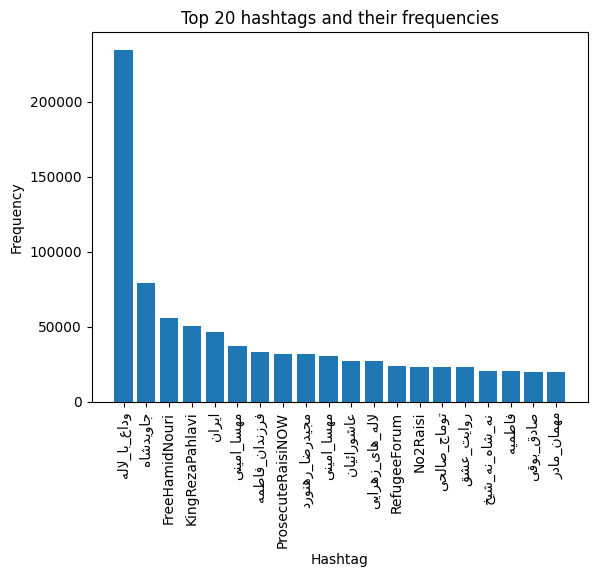

In [7]:
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape

# Take the top 20 hashtags and their frequencies
top_20_hashtags = sorted_hashtag_counts[:20]

# Convert them into two lists
hashtags = [x[0] for x in top_20_hashtags]
frequencies = [x[1] for x in top_20_hashtags]

hashtags = [get_display(reshape(word)) for word in hashtags]

plt.bar(hashtags, frequencies)
plt.xticks(rotation=90)
plt.title("Top 20 hashtags and their frequencies")
plt.xlabel("Hashtag")
plt.ylabel("Frequency")

plt.show()

In [8]:
# Create a new list of only the hashtags
unique_hashtags = [x[0] for x in top_200_hashtags]

# Modify the binary_vector function to check if the hashtag is in the unique_hashtags list
def binary_vector(hashtags):
    # Create a vector of zeros with the same length as the unique_hashtags list
    vector = [0] * len(unique_hashtags)
    
    # Loop over the hashtags and set the corresponding index to one if the hashtag is in the tweet and the unique_hashtags list
    for hashtag in hashtags:
        # Check if the hashtag is in the unique_hashtags list
        if hashtag in unique_hashtags:
            # Find the index of the hashtag in the unique_hashtags list
            index = unique_hashtags.index(hashtag)
        
            # Set the vector value at that index to one
            vector[index] = 1
    
    # Return the vector
    return vector

# Apply the binary_vector function to each element of the hashtag_tweets RDD
binary_tweets = hashtag_tweets.map(lambda x: (x[0], binary_vector(x[1])))

# Check the result
binary_tweets.takeSample(False, 1, 12)

[('1735167478127604210',
  [1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   

In [ ]:
from pyspark.mllib.clustering import KMeans

# Specify the parameters for the K-means algorithm
k = 11 # The number of clusters
maxIterations = 100 # The maximum number of iterations
initializationMode = "random" # The initialization mode
seed = 42 # The seed for random initialization
epsilon = 0.01 # The convergence criterion

# Create a KMeans object with the specified parameters
model = KMeans.train(binary_tweets.map(lambda x: x[1]), k=k, maxIterations=maxIterations, initializationMode=initializationMode, seed=seed, epsilon=epsilon)

# Train the KMeans object on the binary_tweets RDD

# Predict the cluster label for each tweet based on its binary vector
predictions = model.predict(binary_tweets.map(lambda x: x[1]))

# Zip the tweet ID, the binary vector, and the cluster label together
labeled_tweets = binary_tweets.zip(predictions).map(lambda x: (x[0][0], x[1]))

In [10]:
labeled_tweets.take(9)

[('1736536753815834746', 0),
 ('1736536756915249313', 0),
 ('1736536767254134968', 0),
 ('1736536771129741402', 5),
 ('1736536778423607618', 0),
 ('1736536778704875794', 0),
 ('1736536782022246546', 0),
 ('1736536778926919959', 0),
 ('1736536785381908978', 0)]

In [11]:
# Join the labeled_tweets RDD with the tweets_json RDD
joined_tweets = labeled_tweets.join(tweets_json.map(lambda x: (x['id'], x['text'])))

# Filter the joined_tweets RDD by the cluster label 5
cluster_1_tweets = joined_tweets.filter(lambda x: x[1][0] == 1)

# Extract only the text from the cluster_5_tweets RDD
cluster_1_texts = cluster_1_tweets.map(lambda x: x[1][1])

cluster_1_texts.take(9)

['ÿ≥ŸÑÿßŸÖ ÿß€å ŸÜŸàÿ± Ÿáÿ≥ÿ™€å / ÿ≥ŸÑÿßŸÖÿ™ ŸÖ€å ⁄©ŸÜŸÖ / ÿ≥ŸÑÿßŸÖ ÿß€å ⁄ØŸàŸáÿ± ÿ®ŸÇ€åÿπ / ÿ≥ŸÑÿßŸÖÿ™ ŸÖ€å ⁄©ŸÜŸÖ / ÿ≥ŸÑÿßŸÖ ÿß€å ŸÖÿßÿØÿ± ÿÆŸàÿ®ŸÖ / ÿ≥ŸÑÿßŸÖ ÿß€å ÿπŸÅÿ™ Ÿà ÿß€åŸÖÿßŸÜ / ÿ≥ŸÑÿßŸÖÿ™ ŸÖ€å ⁄©ŸÜŸÖ ÿÆÿßŸÜŸàŸÖ / ÿ≥ŸÑÿßŸÖÿ™ ŸÖ€å ⁄©ŸÜŸÖ ÿ®ÿßŸÜŸÄŸÄŸÄŸà / ÿ≥ŸÑÿßŸÖÿ™ ŸÖ€å ⁄©ŸÜŸÖ ŸÖÿßÿØÿ± / ÿ≥ŸÑÿßŸÖÿ™ ŸÖ€å ⁄©ŸÜŸÖ‚Ä¶.#ŸÅÿßÿ∑ŸÖ€åŸàŸÜ',
 'ÿ¨ÿßŸÜŸê ŸÖŸÜ Ÿà ÿ¨ÿßŸÜŸê ŸáŸÖŸá ÿ¥Ÿá€åÿØÿßŸÜŸê ŸÖÿßÿå ÿßÿ±ÿ≤ÿ¥ ŸÅÿØÿß ÿ¥ÿØŸÜ ÿØÿ± ÿ±ÿßŸá ÿß€åŸÜ ŸÖŸÑÿ™ ÿ±ÿß ÿØÿßÿ±ÿØ.\n#ŸàÿØÿßÿπ_ÿ®ÿß_ŸÑÿßŸÑŸá\u200cŸáÿß\n#ŸÅÿßÿ∑ŸÖ€åŸàŸÜ https://t.co/BqOPqSeY9c',
 'ŸÖ€åŸáŸÖÿßŸÜ ŸÖÿßŸÜ ÿÆŸàÿßŸáŸÜÿØ ÿ®ŸàÿØ ŸÑÿßŸÑŸá Ÿáÿß€å€å ⁄©Ÿá ÿ®ÿ±ÿß€å ÿ≥ÿ±ÿ®ŸÑŸÜÿØ€å ŸÖ€åŸáŸÜ ÿßÿ≤ ÿ¨ÿßŸÜ ÿÆŸàÿØ ⁄Øÿ∞ÿ¥ÿ™ŸÜÿØ\xa0 Ÿà ÿ®ÿß ÿÆŸàŸÜÿ¥ÿßŸÜ ÿØŸàÿßŸÖ Ÿà ÿ®ŸÇÿß€å ÿßŸÜŸÇŸÑÿßÿ® ÿßÿ≥ŸÑÿßŸÖ€å ÿ±ÿß ÿ™ÿ∂ŸÖ€åŸÜ ⁄©ÿ±ÿØŸÜÿØ ŸáŸÖŸá ŸÖÿØ€åŸàŸÜ ÿ¢ŸÜŸáÿß€å€åŸÖ ŸÅÿßÿ±ÿ∫ ÿßÿ≤ ÿ≠ÿ≤ÿ® Ÿà ⁄Øÿ±ŸàŸá\n\n#ŸàÿØÿßÿπ_ÿ®ÿß_ŸÑÿßŸÑŸá\u200cŸáÿß \n#ŸÅÿßÿ∑ŸÖ€åŸàŸÜ https://t.co/mQOZKij0Ug',
 'ÿ¥Ÿá€åÿØ ⁄ØŸÖŸÜÿßŸÖÿå ⁄Øÿ±⁄ÜŸá ŸÜÿßŸÖ€å ŸÜÿØÿßÿ±ÿØ ÿßŸÖÿß ŸáŸÖŸá ÿßŸà ÿ±ÿß ÿ®Ÿá 

# NLP

In [13]:
nlp= tweets_json.filter(lambda x: 'nlp' in x)

nlp.take(10)

[{'in_reply_to_status_id_str': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_status_id': None,
  'in_reply_to_user_id': None,
  'in_reply_to_screen_name': None,
  'truncated': False,
  'is_quote_status': False,
  'retweet_count': 0,
  'reply_count': 0,
  'quote_count': 0,
  'favorite_count': 4,
  'favorited': False,
  'retweeted': False,
  'possibly_sensitive': False,
  'lang': 'fa',
  'geo': None,
  'view_count': 262,
  'tweet_type': 'generated',
  'emojis': None,
  'text': '⁄©ÿßÿ±ŸÖŸÜÿØÿßŸÜ Ÿàÿ≤ÿßÿ±ÿ™ ÿßŸÖŸÜ€åÿ™ ÿØÿßÿÆŸÑ€å ÿ¢ŸÖÿ±€å⁄©ÿß ÿÆŸàÿßÿ≥ÿ™ÿßÿ± ÿ¢ÿ™ÿ¥\u200cÿ®ÿ≥ ŸÅŸàÿ±€å ÿØÿ± ÿ∫ÿ≤Ÿá ÿ¥ÿØŸÜÿØ\nhttps://t.co/PDnaJa7Bnp',
  'user': {'id': '22495731',
   'id_str': '22495731',
   'created_at': 1236008662,
   'name': 'ÿßŸÑÿπÿ±ÿ®€åŸá ŸÅÿßÿ±ÿ≥€å',
   'screen_name': 'AlArabiya_Fa',
   'location': 'Dubai',
   'url': 'https://t.co/QI6ab3ILDu',
   'description': '¬´ÿßŸÑÿπÿ±ÿ®ŸäŸá ŸÅÿßÿ±ÿ≥Ÿâ¬ª ÿ®Ÿá ÿπŸÜŸàÿßŸÜ ÿ®ÿÆÿ¥€å ÿßÿ≤ ÿ¥ÿ®ŸÉŸá ¬´ÿßŸÑÿπÿ±ÿ®ŸäŸá¬ª ÿØÿ± ÿ≥ÿßŸÑ 2008 ÿ±ÿßŸá\u200cÿßŸ

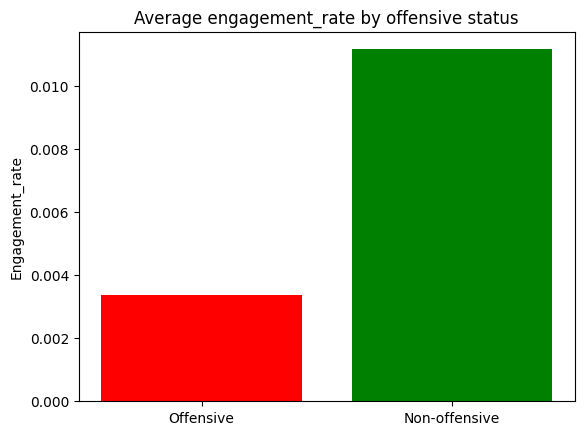

In [15]:
# Import the modules
import matplotlib.pyplot as plt
import numpy as np

# Define a function to extract the engagement_rate and offensive status of the tweets from each tweet
def get_engagement_offensive(tweet):
  engagement_rate = tweet["engagement_rate"]
  offensive = tweet["nlp"]["offensive"]
  return engagement_rate, offensive

# Apply the function to your tweet data using map
engagement_rdd = nlp.filter(lambda x: x.get('nlp').get('offensive')).map(get_engagement_offensive)

# Filter the offensive and non-offensive tweets into two RDDs
offensive_rdd = engagement_rdd.filter(lambda x: x[1] == 'offensive')
non_offensive_rdd = engagement_rdd.filter(lambda x: x[1] == 'non_offensive')

# Calculate the average engagement_rate for each group using mean function
offensive_mean = offensive_rdd.map(lambda x: x[0]).mean()
non_offensive_mean = non_offensive_rdd.map(lambda x: x[0]).mean()

# Create a list of labels and values for plotting
labels = ["Offensive", "Non-offensive"]
values = [offensive_mean, non_offensive_mean]

# Plot the results as a bar chart
plt.bar(labels, values, color=["red", "green"])
plt.title("Average engagement_rate by offensive status")
plt.ylabel("Engagement_rate")
plt.show()


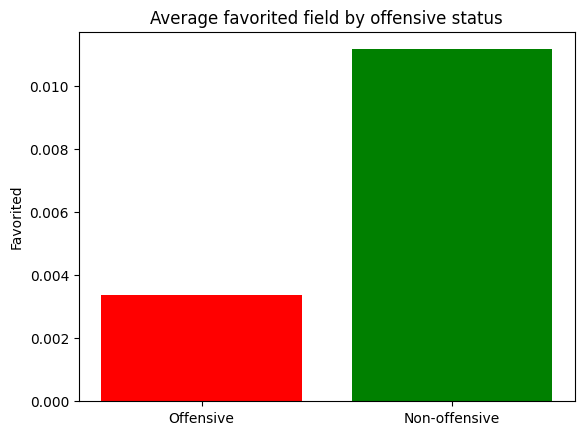

In [16]:
# Import the modules
import matplotlib.pyplot as plt
import numpy as np

# Define a function to extract the favorited field and offensive status of the tweets from each tweet
def get_favorited_offensive(tweet):
  favorited = 1 if tweet["favorited"] else 0
  offensive = tweet["nlp"]["offensive"]
  return favorited, offensive

# Apply the function to your tweet data using map
favorited_rdd = nlp.filter(lambda x: x.get('nlp').get('offensive')).map(get_favorited_offensive)

# Filter the offensive and non-offensive tweets into two RDDs
offensive_rdd = engagement_rdd.filter(lambda x: x[1] == 'offensive')
non_offensive_rdd = engagement_rdd.filter(lambda x: x[1] == 'non_offensive')

# Calculate the average favorited field for each group using mean function
offensive_mean = offensive_rdd.map(lambda x: x[0]).mean()
non_offensive_mean = non_offensive_rdd.map(lambda x: x[0]).mean()

# Create a list of labels and values for plotting
labels = ["Offensive", "Non-offensive"]
values = [offensive_mean, non_offensive_mean]

# Plot the results as a bar chart
plt.bar(labels, values, color=["red", "green"])
plt.title("Average probability to be favorite by offensive status")
plt.ylabel("Favorited")
plt.show()


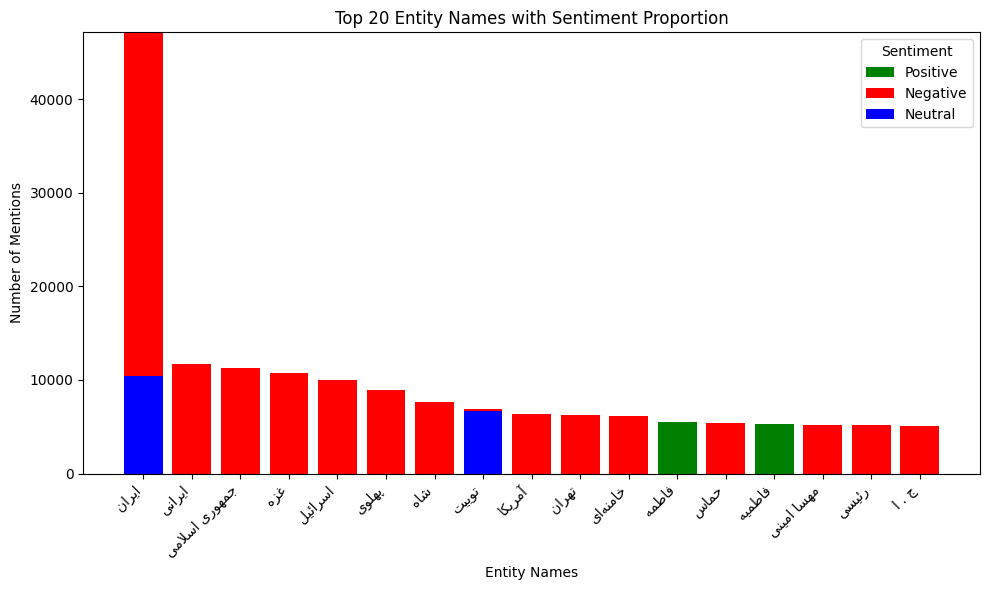

In [14]:
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape

# Filter tweets with named entities
tweets_with_entities = nlp.filter(lambda x: x['nlp']['ner_polarity'])

# Flatten the nested structure and create tuples (entity, sentiment)
entity_sentiment = tweets_with_entities.flatMap(lambda x: [(entity.get('entity', 'UnknownEntity'), x['nlp']['sentiment']) for entity in x['nlp']['ner_polarity']])

# Count the occurrences of each (entity, sentiment) pair
entity_sentiment_counts = entity_sentiment.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda a, b: a + b)

# Get the top 20 entities
top_20_entities = entity_sentiment_counts.takeOrdered(20, key=lambda x: -x[1])


# Separate the data for visualization
entity_sentiment_tuples = [((entity, sentiment), count) for ((entity, sentiment), count) in top_20_entities]
(entities_sentiments, counts) = zip(*entity_sentiment_tuples)

# Extract entities and sentiments from the combined tuple
entities, sentiments = zip(*entities_sentiments)

entities = [get_display(reshape(word)) for word in entities]

# Create a figure for visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a stacked bar chart for each entity
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}
bottom = [0] * len(entities)

for sentiment, color in colors.items():
    counts_for_sentiment = [count if s == sentiment else 0 for (s, count) in zip(sentiments, counts)]
    ax.bar(entities, counts_for_sentiment, bottom=bottom, label=sentiment, color=color)
    bottom = [b + count for b, count in zip(bottom, counts_for_sentiment)]

ax.set_xlabel('Entity Names')
ax.set_ylabel('Number of Mentions')
ax.set_title('Top 20 Entity Names with Sentiment Proportion')
ax.legend(title='Sentiment')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

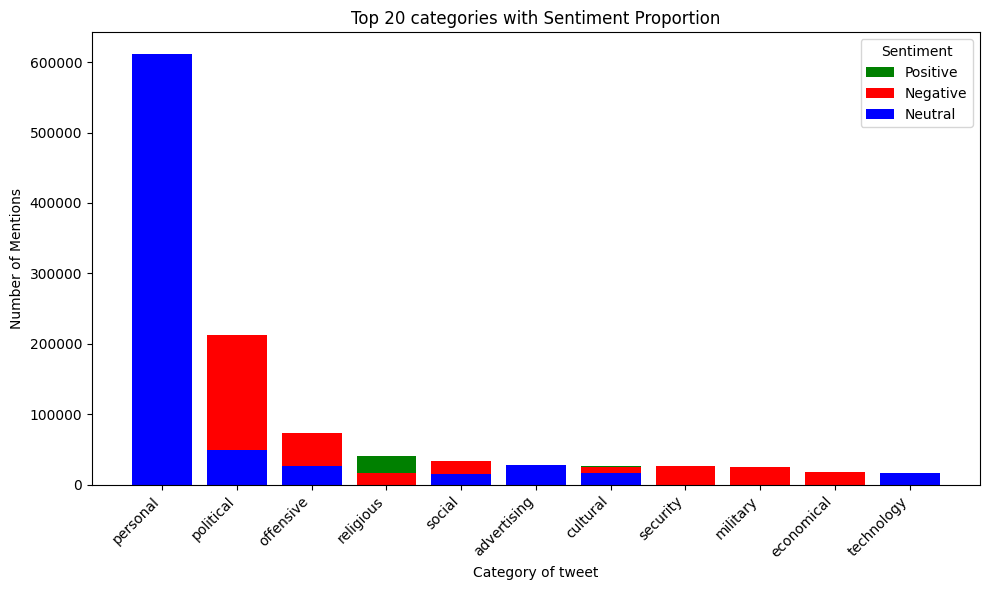

In [15]:
import matplotlib.pyplot as plt

# Filter tweets with named entities
tweets_with_entities = nlp.filter(lambda x: x['nlp']['classification'])

# Flatten the nested structure and create tuples (class, sentiment)
class_sentiment = tweets_with_entities.flatMap(lambda x: [(cluster, x['nlp']['sentiment']) for cluster in x['nlp']['classification']])

# Count the occurrences of each (class, sentiment) pair
class_sentiment_counts = class_sentiment.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda a, b: a + b)

# Get the top 20 classes
top_20_classes = class_sentiment_counts.takeOrdered(20, key=lambda x: -x[1])


# Separate the data for visualization
class_sentiment_tuples = [((classs, sentiment), count) for ((classs, sentiment), count) in top_20_classes]
(classes_sentiments, counts) = zip(*class_sentiment_tuples)

# Extract classes and sentiments from the combined tuple
classes, sentiments = zip(*classes_sentiments)

# Create a figure for visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a stacked bar chart for each class
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'}
bottom = [0] * len(entities)

for sentiment, color in colors.items():
    counts_for_sentiment = [count if s == sentiment else 0 for (s, count) in zip(sentiments, counts)]
    ax.bar(classes, counts_for_sentiment, bottom=bottom, label=sentiment, color=color)
    bottom = [b + count for b, count in zip(bottom, counts_for_sentiment)]

ax.set_xlabel('Category of tweet')
ax.set_ylabel('Number of Mentions')
ax.set_title('Top 20 categories with Sentiment Proportion')
ax.legend(title='Sentiment')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()